In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [89]:
#Get the Dataset
import pandas_datareader.data as web
df = web.DataReader('GOOGL', 'stooq')
df = df[['Close']]
df

,Close
Date,
2024-02-20,141.1200
2024-02-16,140.5200
2024-02-15,142.7700
2024-02-14,145.9400
2024-02-13,145.1400
...,...
2019-02-28,56.3275
2019-02-27,56.1445
2019-02-26,56.1005


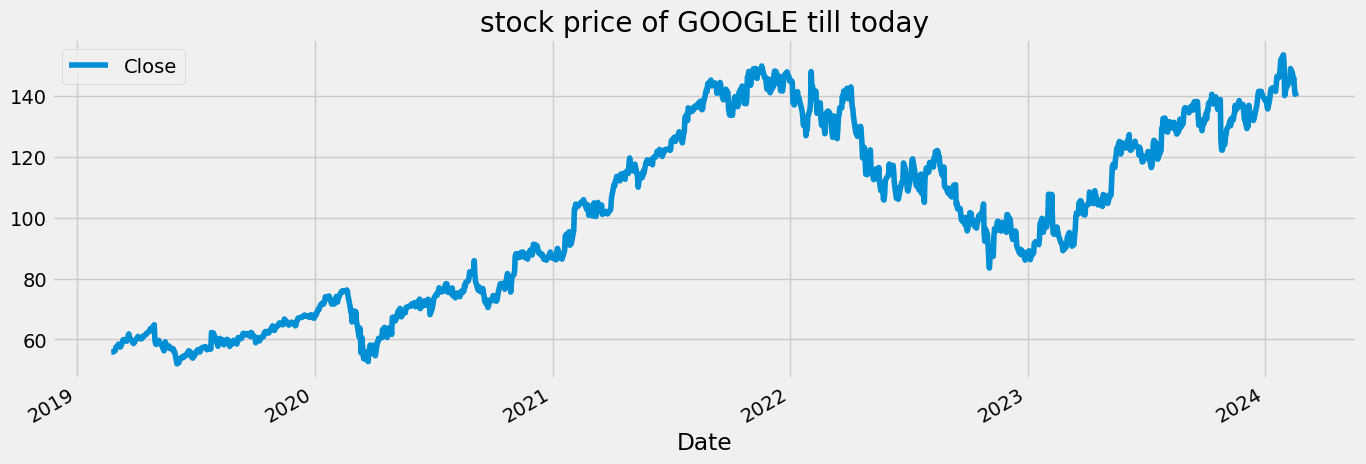

In [90]:
df.plot(style='-',
        figsize=(15, 5),
        color=color_pal[0],
        title='stock price of GOOGLE till today')
plt.show()

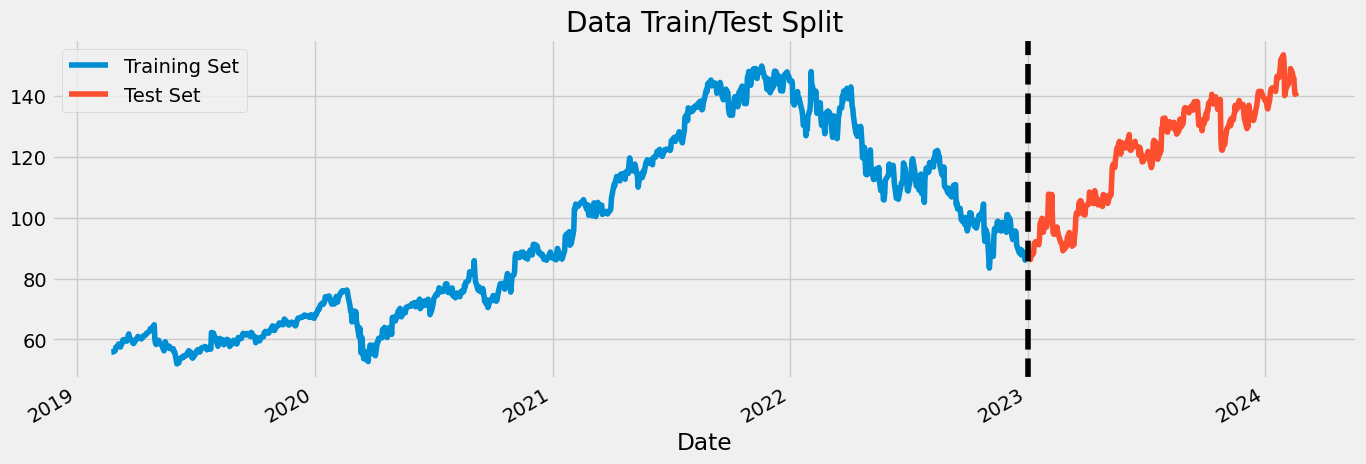

In [91]:
train = df.loc[df.index < '01-01-2023']
test = df.loc[df.index >= '01-01-2023']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2023', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [92]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [93]:
def add_lags(df):
    target_map = df['Close'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [94]:
df = add_lags(df)

In [95]:
from sklearn.model_selection import TimeSeriesSplit
n_splits = 3
test_size = 250
gap = 6

tss = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=gap)

df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'Close'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    

In [96]:
reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

[0]	validation_0-rmse:97.47514	validation_1-rmse:124.83544
[100]	validation_0-rmse:36.56662	validation_1-rmse:60.14166
[200]	validation_0-rmse:14.45045	validation_1-rmse:36.03366
[300]	validation_0-rmse:6.90026	validation_1-rmse:25.96966


/Users/sharath/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:13:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:4.62938	validation_1-rmse:22.24704
[500]	validation_0-rmse:3.85294	validation_1-rmse:20.88744
[567]	validation_0-rmse:3.63921	validation_1-rmse:21.80468


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [97]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'Close'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:103.41114
[100]	validation_0-rmse:38.69829
[200]	validation_0-rmse:15.33859
[300]	validation_0-rmse:7.33109
[400]	validation_0-rmse:4.99475
[499]	validation_0-rmse:4.37453


/Users/sharath/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:13:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [98]:
# Find the last day in the DataFrame df
last_day = df.index[-1]

# Calculate the start date for one year from the last day
start_date = last_day + pd.DateOffset(days=1)

# Calculate the end date as one year from the start date
end_date = start_date + pd.DateOffset(years=1)

# Create future dataframe
forecast = pd.date_range(start_date, end_date, freq='5D')
forecast_df = pd.DataFrame(index=forecast)
forecast_df['isFuture'] = True

# Set isFuture to False for the original DataFrame
df['isFuture'] = False

# Concatenate the original DataFrame and the future DataFrame
df_and_forecast = pd.concat([df, forecast_df])

# Add features and lags
df_and_forecast = create_features(df_and_forecast)
df_and_forecast = add_lags(df_and_forecast)


In [99]:
forecast_w_features = df_and_forecast.query('isFuture').copy()

In [100]:
# Predict using the XGBoost model
forecast_w_features['pred_reg'] = reg.predict(forecast_w_features[FEATURES])


In [101]:
forecast_w_features

,Close,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture,pred_reg
2024-02-21,NaN,0,2,1,2,2024,52,21,8,91.65,127.588,104.190,True,140.534988
2024-02-26,NaN,0,0,1,2,2024,57,26,9,89.87,135.057,103.483,True,140.557678
2024-03-02,NaN,0,5,1,3,2024,62,2,9,NaN,NaN,NaN,True,106.233917
2024-03-07,NaN,0,3,1,3,2024,67,7,10,92.32,132.430,105.027,True,140.534988
2024-03-12,NaN,0,1,1,3,2024,72,12,11,93.97,129.198,104.194,True,140.534988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,NaN,0,4,1,1,2025,31,31,5,142.38,104.780,143.293,True,108.046654
2025-02-05,NaN,0,2,1,2,2025,36,5,6,145.54,99.370,141.592,True,107.664177
2025-02-10,NaN,0,0,1,2,2025,41,10,7,147.53,94.610,135.526,True,107.313683
2025-02-15,NaN,0,5,1,2,2025,46,15,7,NaN,NaN,NaN,True,108.015076


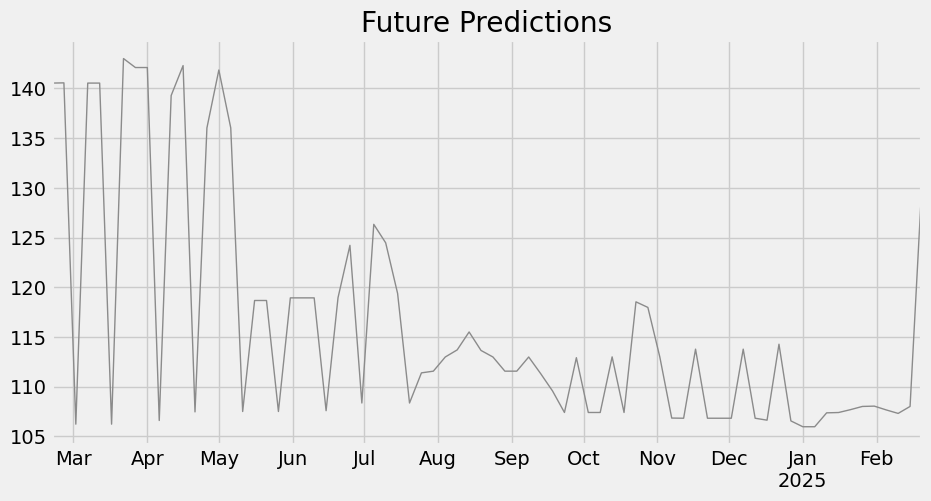

In [102]:
forecast_w_features['pred_reg'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

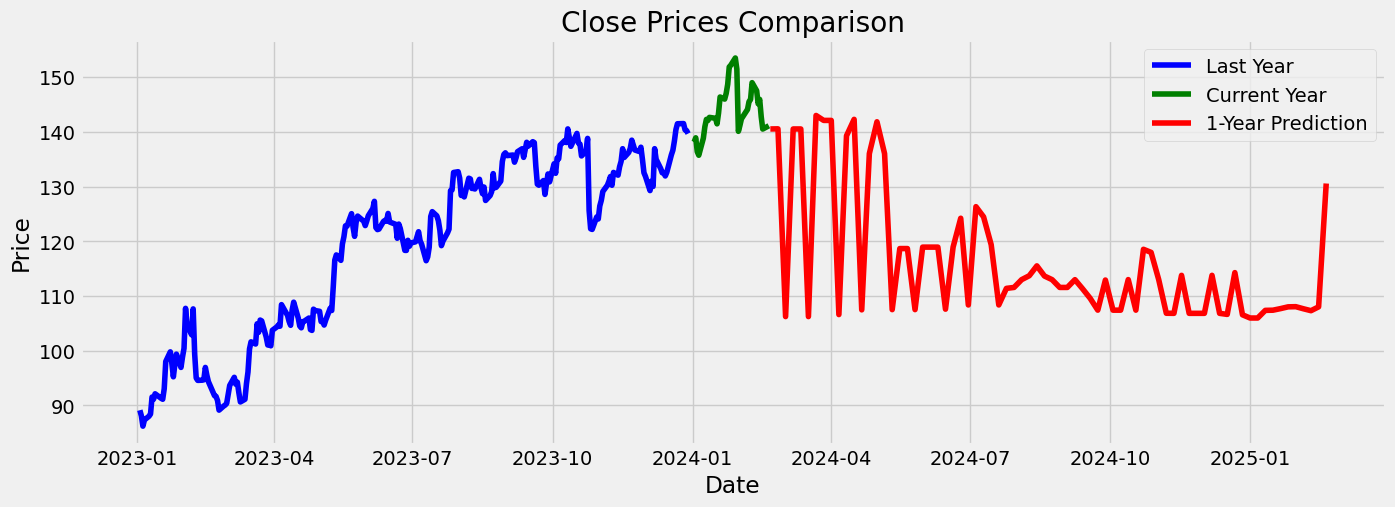

In [103]:
import matplotlib.pyplot as plt

# Set the figure size to increase the width
plt.figure(figsize=(15, 5))

# Filter the DataFrame to include only the last year, current year, and 1-year prediction
last_year_prices = df['Close'].loc[df.index.year == last_day.year - 1]
current_year_prices = df['Close'].loc[df.index.year == last_day.year]
prediction_prices_reg = forecast_w_features['pred_reg']
# Plot the close prices for the last year
plt.plot(last_year_prices.index, last_year_prices, label='Last Year', color='blue')

# Plot the close prices for the current year
plt.plot(current_year_prices.index, current_year_prices, label='Current Year', color='green')

# Plot the 1-year prediction prices
plt.plot(prediction_prices_reg.index, prediction_prices_reg, label='1-Year Prediction', color='red')

# Set the title and labels
plt.title('Close Prices Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.show()


In [104]:
# Find the last day in the DataFrame df
last_day = df.index[-1]

# Calculate the start date for one year from the last day
start_date = last_day + pd.DateOffset(days=1)

# Calculate the end date as one year from the start date
end_date = start_date + pd.DateOffset(years=1)

# Create future dataframe
future = pd.date_range(start_date, end_date, freq='1D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True

# Set isFuture to False for the original DataFrame
df['isFuture'] = False

# Concatenate the original DataFrame and the future DataFrame
df_and_future = pd.concat([df, future_df])

# Add features and lags
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)


In [105]:
future_w_features = df_and_future.query('isFuture').copy()
future_w_features['pred_reg'] = reg.predict(future_w_features[FEATURES])

In [106]:
# Specify the date for which you want to know the prediction
target_date = '2024-02-25'  # Example date

# Query the future_w_features DataFrame for the specified date
prediction_for_date_reg = future_w_features.loc[target_date, 'pred_reg']

# Print the prediction for the specified date
print(f"Prediction for {target_date}: {prediction_for_date_reg}")

Prediction for 2024-02-25: 106.23391723632812
